# Sequence Analysis

## Summary

This notebook contains some of the information regarding sequence analysis.

1. Handling of sequences for protein structure prediction.
2. Sequence logos
3. Calculation of sequence entropy on a multiple alignment
4. Visualization of an *in-silico* alanine scanning experiment.

In [15]:
import prody as pdy
import numpy as np
import logomaker
import pandas as pd
import seaborn as sns
from Bio import AlignIO
from pyfamsa import Aligner, Sequence
from typing import Dict
from scipy.stats import linregress
import matplotlib.pyplot as plt
from Bio.SeqUtils import seq1, seq3
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Sequence Analysis and management

In [16]:
def align_structure_sequences(proteins: Dict[str, pdy.AtomGroup], chain):
    """
    Generates a list of aligned sequences

    arguments
    ---------
    - proteins: List[pdy.AtomGroup]
    - chain: str
    
    """
    # Align Sequence
    sequence_records = []
    for key, protein in proteins.items():
        sequence_records.append(
            Sequence(key.encode(), protein.select(f'chain {chain:s} and name CA').getSequence().encode())
        )
    
    aligner = Aligner()
    msa = aligner.align(sequence_records)
    # return [dict(id=item.id.decode(), sequence=item.sequence.decode()) for item in msa]
    return [[item.id.decode()] + list(item.sequence.decode()) for item in msa]


def map_alignment_to_structure(alignment, structures, on_chain):
    """
    Returns a dataframe with the sequence alignment and mappings to its residues

    arguments
    ---------
    - proteins: List[pdy.AtomGroup]
    - chain: str

    """
    alignment = pd.DataFrame(alignment).set_index(0).T
    for column in alignment.columns:
        structure = structures[column]
        seq = alignment[column].to_list()
        chain = structure.select(f'chain {on_chain:s}').getHierView()
        residues = list(chain.iterResidues())
        residue_list = []
        active = False
        for i, pos in enumerate(seq):
            if len(residues) == 0:
                residue_list.append(None)
                continue
            
            if pos == '-': 
                residue_list.append(None)
                continue
            
            if pos == residues[0].select('name CA').getSequence():
                residue_list.append(residues.pop(0))

        if len(residues) > 0:
            raise RuntimeError("sequence failed to map")
        alignment['map:' + column] = residue_list

    return alignment

def get_position_entropy(u):
    """
    Useful to compute the entropy of the alignment
    """
    u = np.array(u)
    probs = []
    for char in np.unique(u):
        probs.append(((u == char).sum() / len(u)))
    
    return entropy(probs, base=2)


def get_coord_sets(alignment):
    coordinates = []
    for column in filter(lambda x: x[:3] == 'map', alignment.columns):
        coordinates.append(alignment.query('entropy < 0.01').apply(lambda x: x[column].select('name CA').getCoords().reshape(-1).tolist(), axis=1).to_list())
    return np.array(coordinates)

## Sequence concatenation for structure predicton

In [17]:
import pandas as pd
from Bio import SeqIO

In [18]:
K_seqs = list(SeqIO.parse('../seq/K.fasta', format='fasta'))
D_seqs = list(SeqIO.parse('../seq/D.fasta', format='fasta'))
G_seqs = list(SeqIO.parse('../seq/G.fasta', format='fasta'))
H_seqs = list(SeqIO.parse('../seq/H.fasta', format='fasta'))
H2_seqs = list(SeqIO.parse('../seq/H.fasta', format='fasta'))
# Workaround to generate H subunit dimers 
for seq in H2_seqs:
    seq.name = seq.name.replace('H_', 'H2_')
# Generating records from the multiple sequence alignments
alignment_source = []
for alignment in [K_seqs, D_seqs, G_seqs, H_seqs, H2_seqs]:
    for sequence in alignment:
        alignment_source.append(
            dict(id=sequence.name, seq=str(sequence.seq).replace('-', ''))
        )
nitrogenase_sequences = pd.DataFrame.from_records(alignment_source)
# Formatting
nitrogenase_sequences['subunit'] = nitrogenase_sequences.id.apply(lambda x: x.split('_')[0])
nitrogenase_sequences['gene'] = nitrogenase_sequences.id.apply(lambda x: x.split('_')[1])
nitrogenase_sequences['organism'] = nitrogenase_sequences.id.apply(lambda x: x.split('_')[2] if len(x.split('_')) >= 3 else "Anc")
nitrogenase_sequences.set_index(['subunit', 'gene', 'organism'], inplace=True)

In [19]:
nitrogenase_sequences[:5]

id  \
subunit gene organism                                             
K       Nif  Azotobacter           K_Nif_Azotobacter_vinelandii   
        Vnf  Azotobacter           K_Vnf_Azotobacter_vinelandii   
        Anf  Azotobacter           K_Anf_Azotobacter_vinelandii   
        Nif  Methanobacterium    K_Nif_Methanobacterium_paludis   
        Vnf  Methanosarcina    K_Vnf_Methanosarcina_acetivorans   

                                                                             seq  
subunit gene organism                                                             
K       Nif  Azotobacter       MSQQVDKIKASYPLFLDQDYKDMLAKKRDGFEEKYPQDKIDEVFQW...  
        Vnf  Azotobacter       MSNCELTVLKPAEVKLSPRDREGIINPMYDCQPAGAQYAGIGIKDC...  
        Anf  Azotobacter       MTCEVKEKGRVGTINPIFTCQPAGAQFVSIGIKDCIGIVHGGQGCV...  
        Nif  Methanobacterium  MSGINVIKRERNVIINPLKTCQPLGAMFAVMGVHHGFPLVHGSQGC...  
        Vnf  Methanosarcina    MSCELMLKERTGIINPMYTCQPAGAQYAGIGVKDCIPLVHGGQGCS...

In [20]:
def concatenate_sequences(
    id, seq_codes
):
    sequences = []
    for sc in seq_codes:
        sequences.append(nitrogenase_sequences.loc[sc[0], sc[1], sc[2]].seq)
    seq = ':'.join(sequences)
    return dict(
        id=id, seq_codes='/'.join(['.'.join(u) for u in seq_codes]), sequence=seq
    )

In [21]:
concatenate_sequences('construct1', 
    [('K', 'Anf', 'Azotobacter'),('D', 'Anf', 'Azotobacter'), ('G', 'Anf', 'Azotobacter')]
)

{'id': 'construct1',
 'seq_codes': 'K.Anf.Azotobacter/D.Anf.Azotobacter/G.Anf.Azotobacter',
 'sequence': 'MTCEVKEKGRVGTINPIFTCQPAGAQFVSIGIKDCIGIVHGGQGCVMFVRLIFSQHYKESFELASSSLHEDGAVFGACGRVEEAVDVLLSRYPDVKVVPIITTCSTEIIGDDVDGVIKKLNEGLLKEKFPDREVHLIAMHTPSFVGSMISGYDVAVRDVVRHFAKREAPNDKINLLTGWVNPGDVKELKHLLGEMDIEANVLFEIESFDSPILPDGSAVSHGNTTIEDLIDTGNARATFALNRYEGTKAAEYLQKKFEIPAIIGPTPIGIRNTDIFLQNLKKATGKPIPQSLAHERGVAIDALADLTHMFLAEKRVAIYGAPDLVIGLAEFCLDLEMKPVLLLLGDDNSKYVDDPRIKALQENVDYGMEIVTNADFWELENRIKNEGLELDLILGHSKGRFISIDYNIPMLRVGFPTYDRAGLFRYPTVGYGGAIWLAEQMANTLFADMEHKKNKEWVLNVW:MPHHEFECSKVIPERKKHAVIKGKGETLADALPQGYLNTIPGSISERGCAYCGAKHVIGTPMKDVIHISHGPVGCTYDTWQTKRYISDNDNFQLKYTYATDVKEKHIVFGAEKLLKQNIIEAFKAFPQIKRMTIYQTCATALIGDDINAIAEEVMEEMPEVDIFVCNSPGFAGPSQSGGHHKINIAWINQKVGTVEPEITGDHVINYVGEYNIQGDQEVMVDYFKRMGIQVLSTFTGNGSYDGLRAMHRAHLNVLECARSAEYICNELRVRYGIPRLDIDGFGFKPLADSLRKIGMFFGIEDRAKAIIDEEVARWKPELDWYKERLMGKKVCLWPGGSKLWHWAHVIEEEMGLKVVSVYTKFGHQGDMEKGIARCGEGTLAIDDPNELEGLEALEMLKPDIILTGKRPGEVAKKVRVPYLNAHAYHNGPYK

### Colabfold prediction of DKGHH structure

In [22]:
dkghh_sequences = [
    # azotobacter
    concatenate_sequences('AzoV.Nif.DKHH', [('K', 'Nif', 'Azotobacter'),('D', 'Nif', 'Azotobacter'), ('H', 'Nif', 'Azotobacter'), ('H2', 'Nif', 'Azotobacter')]),
    concatenate_sequences('AzoV.Vnf.GDKHH', [('K', 'Vnf', 'Azotobacter'),('D', 'Vnf', 'Azotobacter'), ('G', 'Vnf', 'Azotobacter'), ('H', 'Vnf', 'Azotobacter'), ('H2', 'Vnf', 'Azotobacter')]),
    concatenate_sequences('AzoV.Anf.GDKHH', [('K', 'Anf', 'Azotobacter'),('D', 'Anf', 'Azotobacter'), ('G', 'Anf', 'Azotobacter'), ('H', 'Anf', 'Azotobacter'), ('H2', 'Anf', 'Azotobacter')]),
    # methanosarcina
    concatenate_sequences('MetA.Nif.DKHH', [('K', 'Nif', 'Methanosarcina'),('D', 'Nif', 'Methanosarcina'), ('H', 'Nif', 'Methanosarcina'), ('H2', 'Nif', 'Methanosarcina')]),
    concatenate_sequences('MetA.Vnf.GDKHH', [('K', 'Vnf', 'Methanosarcina'),('D', 'Vnf', 'Methanosarcina'), ('G', 'Vnf', 'Methanosarcina'), ('H', 'Vnf', 'Methanosarcina'), ('H2', 'Vnf', 'Methanosarcina')]),
    # methanobacterium
    concatenate_sequences('MetP.Nif.DKHH', [('K', 'Nif', 'Methanobacterium'),('D', 'Nif', 'Methanobacterium'),  ('H', 'Nif', 'Methanobacterium'), ('H2', 'Nif', 'Methanobacterium')]),
    # ancestors
    concatenate_sequences('Anc262.GDKHH', [('K', 'Anc262', 'Anc'),('D', 'Anc262', 'Anc'), ('G', 'Anc262', 'Anc'), ('H', 'Anc262', 'Anc'), ('H2', 'Anc262', 'Anc')]),
    concatenate_sequences('Anc263.GDKHH', [('K', 'Anc263', 'Anc'),('D', 'Anc263', 'Anc'), ('G', 'Anc263', 'Anc'), ('H', 'Anc263', 'Anc'), ('H2', 'Anc263', 'Anc')]),
    concatenate_sequences('Anc264.DKHH', [('K', 'Anc264', 'Anc'),('D', 'Anc264', 'Anc'), ('H', 'Anc264', 'Anc'), ('H2', 'Anc264', 'Anc')]),
    concatenate_sequences('Anc265.DKHH', [('K', 'Anc265', 'Anc'),('D', 'Anc265', 'Anc'), ('H', 'Anc265', 'Anc'), ('H2', 'Anc265', 'Anc')]),
    concatenate_sequences('Anc330.GDKHH', [('K', 'Anc330', 'Anc'),('D', 'Anc330', 'Anc'), ('G', 'Anc330', 'Anc'), ('H', 'Anc330', 'Anc'), ('H2', 'Anc330', 'Anc')]),
]
dkghh_sequences = pd.DataFrame.from_records(dkghh_sequences)
dkghh_sequences['seqlen'] = dkghh_sequences['sequence'].apply(lambda x: len(x.replace(':','')))
dkghh_sequences['subunits'] = dkghh_sequences['sequence'].apply(lambda x: x.count(':') + 1)

In [23]:
dkghh_sequences

,id,seq_codes,sequence,seqlen,subunits
0,AzoV.Nif.DKHH,K.Nif.Azotobacter/D.Nif.Azotobacter/H.Nif.Azot...,MSQQVDKIKASYPLFLDQDYKDMLAKKRDGFEEKYPQDKIDEVFQW...,1595,4
1,AzoV.Vnf.GDKHH,K.Vnf.Azotobacter/D.Vnf.Azotobacter/G.Vnf.Azot...,MSNCELTVLKPAEVKLSPRDREGIINPMYDCQPAGAQYAGIGIKDC...,1642,5
2,AzoV.Anf.GDKHH,K.Anf.Azotobacter/D.Anf.Azotobacter/G.Anf.Azot...,MTCEVKEKGRVGTINPIFTCQPAGAQFVSIGIKDCIGIVHGGQGCV...,1662,5
3,MetA.Nif.DKHH,K.Nif.Methanosarcina/D.Nif.Methanosarcina/H.Ni...,MLDYTPCEEVERSAITINPAKICQPIGAVYAALGVHNCMPHSHGSQ...,1530,4
4,MetA.Vnf.GDKHH,K.Vnf.Methanosarcina/D.Vnf.Methanosarcina/G.Vn...,MSCELMLKERTGIINPMYTCQPAGAQYAGIGVKDCIPLVHGGQGCS...,1603,5
5,MetP.Nif.DKHH,K.Nif.Methanobacterium/D.Nif.Methanobacterium/...,MSGINVIKRERNVIINPLKTCQPLGAMFAVMGVHHGFPLVHGSQGC...,1505,4
6,Anc262.GDKHH,K.Anc262.Anc/D.Anc262.Anc/G.Anc262.Anc/H.Anc26...,MSCTVKQKERTGIINPMYTCQPCGAQYASIGIKDCIPLVHGGQGCS...,1594,5
7,Anc263.GDKHH,K.Anc263.Anc/D.Anc263.Anc/G.Anc263.Anc/H.Anc26...,MSCTVKQKERTGIINPMYTCQPCGAQYASIGIKDCIPLVHGGQGCS...,1594,5
8,Anc264.DKHH,K.Anc264.Anc/D.Anc264.Anc/H.Anc264.Anc/H2.Anc2...,MSETVTKKERTAVINPMKTCQPLGAMYATLGIHRAIPLVHGSQGCS...,1460,4
9,Anc265.DKHH,K.Anc265.Anc/D.Anc265.Anc/H.Anc265.Anc/H2.Anc2...,MSTLVTKKNRTVTINPAKTCQPIGAMYATLGVHRAIPLVQGSQGCS...,1460,4


In [24]:
dkghh_sequences.to_csv('../seq/dkghh.colabready.csv', sep=",", index=None)

## Colabfold prediction for cross-docking experiments

Those experiments aimed to use the excesive power of colabfold to predict multimeric structures as an indication of whether some structures make sense or not.

In [25]:
# Construct VnfD/VnfG/AnfG
cross_docking = []
cross_docking.append(concatenate_sequences('construct1', [('K', 'Vnf', 'Azotobacter'),('D', 'Vnf', 'Azotobacter'), ('G', 'Anf', 'Azotobacter')]))
cross_docking.append(concatenate_sequences('construct2', [('K', 'Anf', 'Azotobacter'),('D', 'Anf', 'Azotobacter'), ('G', 'Vnf', 'Azotobacter')]))
cross_docking.append(concatenate_sequences('construct3', [('K', 'Anf', 'Azotobacter'),('D', 'Anf', 'Azotobacter'), ('G', 'Anc263', 'Anc')]))
cross_docking.append(concatenate_sequences('construct4', [('K', 'Vnf', 'Azotobacter'),('D', 'Vnf', 'Azotobacter'), ('G', 'Anc263', 'Anc')]))
cross_docking.append(concatenate_sequences('construct5', [('K', 'Anc264', 'Anc'),('D', 'Anc264', 'Anc'), ('G', 'Anc263', 'Anc')]))
cross_docking.append(concatenate_sequences('construct6', [('K', 'Nif', 'Azotobacter'),('D', 'Nif', 'Azotobacter'), ('G', 'Vnf', 'Azotobacter')]))
cross_docking.append(concatenate_sequences('construct7', [('K', 'Anc265', 'Anc'),('D', 'Anc265', 'Anc'), ('G', 'Anc263', 'Anc')]))


cross_docking = pd.DataFrame.from_records(cross_docking)
cross_docking['seqlen'] = cross_docking['sequence'].apply(lambda x: len(x.replace(':','')))
cross_docking['subunits'] = cross_docking['sequence'].apply(lambda x: x.count(':') + 1)

cross_docking


,id,seq_codes,sequence,seqlen,subunits
0,construct1,K.Vnf.Azotobacter/D.Vnf.Azotobacter/G.Anf.Azot...,MSNCELTVLKPAEVKLSPRDREGIINPMYDCQPAGAQYAGIGIKDC...,1081,3
1,construct2,K.Anf.Azotobacter/D.Anf.Azotobacter/G.Vnf.Azot...,MTCEVKEKGRVGTINPIFTCQPAGAQFVSIGIKDCIGIVHGGQGCV...,1093,3
2,construct3,K.Anf.Azotobacter/D.Anf.Azotobacter/G.Anc263.Anc,MTCEVKEKGRVGTINPIFTCQPAGAQFVSIGIKDCIGIVHGGQGCV...,1092,3
3,construct4,K.Vnf.Azotobacter/D.Vnf.Azotobacter/G.Anc263.Anc,MSNCELTVLKPAEVKLSPRDREGIINPMYDCQPAGAQYAGIGIKDC...,1061,3
4,construct5,K.Anc264.Anc/D.Anc264.Anc/G.Anc263.Anc,MSETVTKKERTAVINPMKTCQPLGAMYATLGIHRAIPLVHGSQGCS...,1024,3
5,construct6,K.Nif.Azotobacter/D.Nif.Azotobacter/G.Vnf.Azot...,MSQQVDKIKASYPLFLDQDYKDMLAKKRDGFEEKYPQDKIDEVFQW...,1128,3
6,construct7,K.Anc265.Anc/D.Anc265.Anc/G.Anc263.Anc,MSTLVTKKNRTVTINPAKTCQPIGAMYATLGVHRAIPLVQGSQGCS...,1024,3


In [26]:
dkghh_sequences.to_csv('../seq/cross-docking.colabready.csv', sep=",", index=None)

## Sequence Identity Plots

In [27]:
def alignment2matrix(alignment):
    alignment = [seq for seq in alignment]
    labels = [seq.id[:25] for seq in alignment]

    matrix = np.zeros((len(alignment), len(alignment)))
    for i, seq1 in enumerate(alignment):
        for j, seq2 in enumerate(alignment):
            if seq1.id == seq2.id:
                pass
            seq_identity = 0
            min_length = min([len(str(seq1.seq).replace('-','')), len(str(seq2.seq).replace('-',''))])
            for c1, c2 in zip(str(seq1.seq), str(seq2.seq)):
                if c1 == c2 and (c1 != "-" and c2 != "-"):
                    seq_identity += 1

            matrix[i,j] = (seq_identity / min_length) * 100
    return matrix, labels

In [28]:
alignment = AlignIO.read("../seq/G.align.ordered.fasta", 'fasta')
G_matrix, G_labels  = alignment2matrix(alignment)
alignment = AlignIO.read("../seq/D.align.ordered.fasta", 'fasta')
D_matrix, D_labels  = alignment2matrix(alignment)

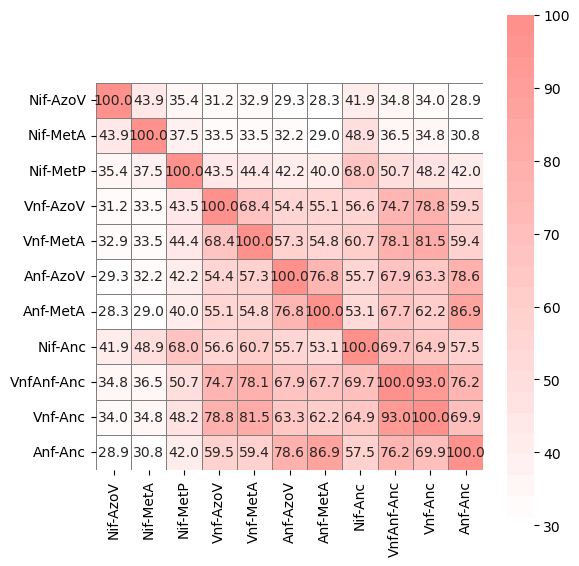

In [29]:
fig, ax = plt.subplots(1 , 1)
fig.set_size_inches(6, 6)
ax.set_aspect('equal')
mask = np.triu(np.ones_like(D_matrix, dtype=bool))
palette = sns.blend_palette(['#FFFFFF', '#FF918C'], n_colors=25)
sns.heatmap(D_matrix, cmap=palette, ax=ax, xticklabels=D_labels, yticklabels=D_labels, fmt='2.1f', annot=True, linewidths=.5, linecolor='gray')
#ax.set_title('D subunit - identity')
fig.tight_layout()
fig.savefig('../figures/identity-matrix.D-subunit.svg')

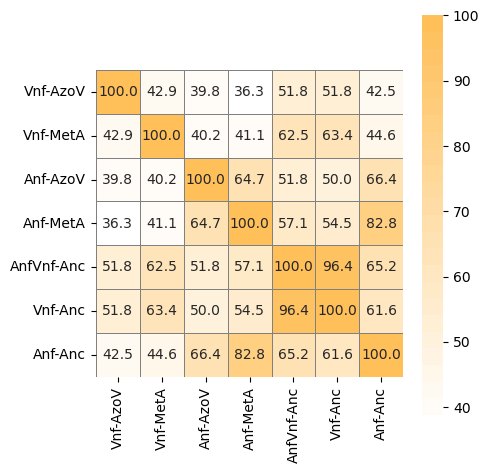

In [30]:
fig, ax = plt.subplots(1 , 1)
fig.set_size_inches(5, 5)
ax.set_aspect('equal')
mask = np.zeros_like(G_matrix)
mask = np.triu(np.ones_like(D_matrix, dtype=bool))
palette = sns.blend_palette(['#FFFFFF', '#FFBF59'], n_colors=25)
sns.heatmap(G_matrix, cmap=palette, ax=ax, xticklabels=G_labels, yticklabels=G_labels, fmt='2.1f', annot=True, linewidths=.5, linecolor='gray')

fig.tight_layout()
fig.savefig('../figures/identity-matrix.G-subunit.svg')
#ax[1].set_title('G subunit - identity')

### Sequence Logos

(-0.475, 7.475, 0.0, 1.0)

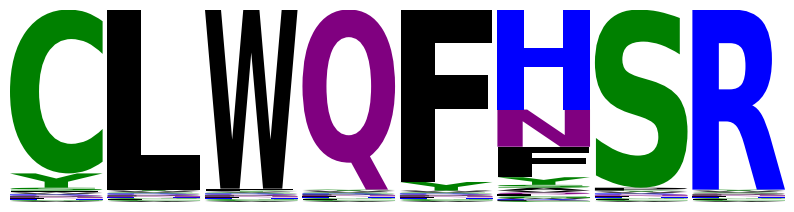

In [31]:
with open('../seq/G.central_domain.fasta') as f:
    raw_seqs = f.readlines()
seqs = [seq.strip() for seq in raw_seqs if ('#' not in seq) and ('>') not in seq]

counts_mat = logomaker.alignment_to_matrix(seqs)
prob_mat = logomaker.transform_matrix(counts_mat, from_type='counts', to_type='probability')
info_mat = logomaker.transform_matrix(counts_mat, from_type='counts', to_type='information')
logo = logomaker.Logo(prob_mat, font_name='DejaVu Sans', color_scheme='chemistry')
logo.style_xticks(spacing=5, anchor=25, rotation=45, fmt='', fontsize=14)
plt.axis('off')
# plt.savefig('../figures/fig11.G2.logo.png', dpi=300)


(-0.475, 9.475, 0.0, 1.0000000000000004)

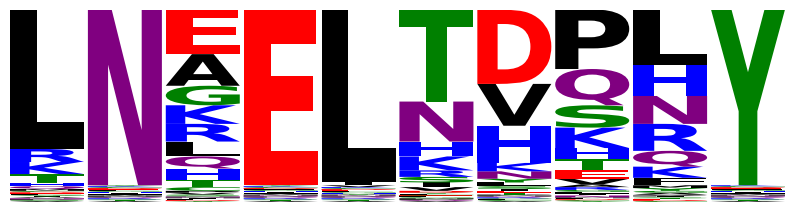

In [32]:
with open('../seq/G_cterminal.fasta') as f:
    raw_seqs = f.readlines()
seqs = [seq.strip() for seq in raw_seqs if ('#' not in seq) and ('>') not in seq]

counts_mat = logomaker.alignment_to_matrix(seqs)
prob_mat = logomaker.transform_matrix(counts_mat, from_type='counts', to_type='probability')
info_mat = logomaker.transform_matrix(counts_mat, from_type='counts', to_type='information')

logo = logomaker.Logo(prob_mat, font_name='DejaVu Sans', color_scheme='chemistry')
logo.style_xticks(spacing=5, anchor=25, rotation=45, fmt='', fontsize=14)
plt.axis('off')
#plt.savefig('../figures/fig11.G3.logo.png', dpi=300)

### Sequence Conservation Analysis

In [33]:
import prody as pdy
import matplotlib.pyplot as plt
from Bio.AlignIO import read
import numpy as np
from scipy.stats import entropy
import seaborn as sns
import pandas as pd
def get_position_entropy(u):
    u = np.array(u)
    probs = []
    for char in np.unique(u):
        probs.append(((u == char).sum() / len(u)))
    
    return entropy(probs, base=2)


In [34]:
G_subunit_alignment = read('../seq/AGNifAlign115.fasta', format='fasta')
position_conservation = np.zeros(len(G_subunit_alignment[0].seq))

entropy_records = []

for i in range(position_conservation.size):
    positions = []
    for seq in G_subunit_alignment:
        positions.append(seq.seq[i])
    position_conservation[i] = get_position_entropy(positions)

azov_vnf_g_subunit = pdy.parsePDB('../structure/5n6y.G.pdb')

azov_vnf_g_subunit_entropy = []
azov_vnf_g_subunit_sequence = []

for i, char in enumerate(str(G_subunit_alignment[8].seq)):
    if char == '-': 
        continue 
    else:
        azov_vnf_g_subunit_entropy.append(position_conservation[i])
        azov_vnf_g_subunit_sequence.append(char)
azov_vnf_g_subunit_entropy = np.array(azov_vnf_g_subunit_entropy[1:])
azov_vnf_g_subunit_sequence = azov_vnf_g_subunit_sequence[1:]
    

for residue, S, c in zip(azov_vnf_g_subunit.getHierView().iterResidues(), azov_vnf_g_subunit_entropy, azov_vnf_g_subunit_sequence):
    print(f"{residue.getResindex():3d}, {residue.getResname():3s}, {c:s}, {S:8.2f}")
    entropy_records.append({
        "chain": "C", "res-number":residue.getResnum(), "entropy":S, "wild-type": residue.getResname()
    })
    residue.setBetas(1 - S)

  0, SER, S,     3.12
  1, GLN, Q,     3.01
  2, SER, S,     2.66
  3, HIS, H,     1.95
  4, LEU, L,     2.39
  5, ASP, D,     2.44
  6, ASP, D,     2.51
  7, LEU, L,     1.25
  8, PHE, F,     2.84
  9, ALA, A,     2.44
 10, TYR, Y,     1.27
 11, VAL, V,     0.99
 12, GLU, E,     1.52
 13, GLU, E,     1.32
 14, ARG, R,     2.33
 15, CYS, C,     0.51
 16, LEU, L,     0.00
 17, TRP, W,     0.05
 18, GLN, Q,     0.00
 19, PHE, F,     0.25
 20, PHE, F,     1.84
 21, SER, S,     0.08
 22, ARG, R,     0.00
 23, THR, T,     2.39
 24, TRP, W,     0.08
 25, ASP, D,     0.00
 26, ARG, R,     0.00
 27, GLU, E,     2.14
 28, GLU, E,     2.51
 29, ASN, N,     1.00
 30, ILE, I,     1.00
 31, GLU, E,     2.21
 32, GLY, G,     1.29
 33, VAL, V,     0.96
 34, LEU, L,     1.25
 35, ASN, N,     3.09
 36, GLN, Q,     2.30
 37, VAL, V,     1.49
 38, GLY, G,     3.33
 39, ARG, R,     2.27
 40, LEU, L,     1.17
 41, LEU, L,     0.59
 42, THR, T,     2.26
 43, GLY, G,     1.60
 44, GLN, Q,     1.26
 45, GLU, 

In [35]:
# pdy.writePDB('G.subunit.entropy.pdb', azov_vnf_g_subunit)

In [36]:
entropy_records = pd.DataFrame.from_records(entropy_records)
entropy_records['char'] = azov_vnf_g_subunit_sequence
entropy_records['coolname'] = entropy_records[['res-number', 'char']].apply(lambda x: '{:s}{:d}'.format(x['char'], x['res-number']), axis=1)#), axis=0)
entropy_records['1-S'] = 1-entropy_records['entropy']
entropy_records

,chain,res-number,entropy,wild-type,char,coolname,1-S
0,C,2,3.119143,SER,S,S2,-2.119143
1,C,3,3.014598,GLN,Q,Q3,-2.014598
2,C,4,2.657613,SER,S,S4,-1.657613
3,C,5,1.954174,HIS,H,H5,-0.954174
4,C,6,2.388688,LEU,L,L6,-1.388688
...,...,...,...,...,...,...,...
107,C,109,2.094485,ASN,N,N109,-1.094485
108,C,110,2.238070,HIS,H,H110,-1.238070
109,C,111,2.831251,HIS,H,H111,-1.831251
110,C,112,2.723373,LEU,L,L112,-1.723373


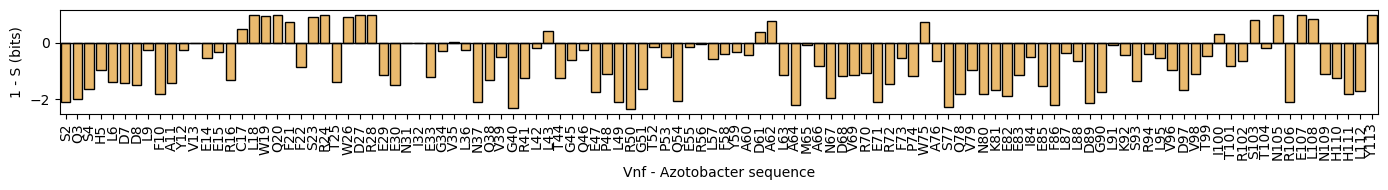

In [37]:
fig, ax = plt.subplots(1)
fig.set_size_inches(14, 2)
sns.barplot(x='coolname', y='1-S', data=entropy_records, color='#FFBF59', edgecolor='black')
#ax.set_xticks(np.arange(len(azov_vnf_g_subunit_sequence)))
#ax.set_xticklabels(list(azov_vnf_g_subunit_sequence))
ax.set_ylabel('1 - S (bits)')
ax.set_xlabel('Vnf - Azotobacter sequence')
ax.axhline(0, linewidth=1, color='black')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
#fig.savefig('../figures/fig010.VnfG.AzoV.seqentropy.svg', dpi=300)
plt.show()

In [38]:
entropy_df = pd.DataFrame.from_records(entropy_records)
entropy_df

,chain,res-number,entropy,wild-type,char,coolname,1-S
0,C,2,3.119143,SER,S,S2,-2.119143
1,C,3,3.014598,GLN,Q,Q3,-2.014598
2,C,4,2.657613,SER,S,S4,-1.657613
3,C,5,1.954174,HIS,H,H5,-0.954174
4,C,6,2.388688,LEU,L,L6,-1.388688
...,...,...,...,...,...,...,...
107,C,109,2.094485,ASN,N,N109,-1.094485
108,C,110,2.238070,HIS,H,H110,-1.238070
109,C,111,2.831251,HIS,H,H111,-1.831251
110,C,112,2.723373,LEU,L,L112,-1.723373


## Alanine Scanning

We use data coming from applying mCSM2 [Pires et al 2021]() in *Azotbacter vinelandii* Vnf system.

In [39]:
mcsm2_df = pd.read_csv('../data/mcsm2/AzoV.Vnf.DG.mcsm2.csv').query('chain == "C"')
mcsm2_df[:10]

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity
1,C,LEU,18,ALA,3.524,-1.378,Decreasing
3,C,PHE,22,ALA,3.548,-2.226,Decreasing
11,C,TYR,59,ALA,3.988,-1.637,Decreasing
12,C,ASP,27,ALA,4.290,-1.455,Decreasing
14,C,ASP,61,ALA,2.722,-0.971,Decreasing
15,C,PHE,10,ALA,4.574,-0.565,Decreasing
18,C,TYR,113,ALA,2.901,-1.811,Decreasing
19,C,ARG,102,ALA,2.660,-0.700,Decreasing
20,C,GLU,30,ALA,2.877,-0.456,Decreasing
21,C,GLU,107,ALA,2.750,-1.101,Decreasing


In [40]:
entropy_df.query('chain == "C"')[entropy_df['res-number'] == 18]

,chain,res-number,entropy,wild-type,char,coolname,1-S
16,C,18,0.0,LEU,L,L18,1.0


In [41]:
ala_scanning_entropy = pd.merge(entropy_records, mcsm2_df, on=['chain', 'res-number', 'wild-type'], how='left')

In [42]:
ala_scanning_entropy[ala_scanning_entropy['res-number'] == 18]

,chain,res-number,entropy,wild-type,char,coolname,1-S,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity
16,C,18,0.0,LEU,L,L18,1.0,ALA,3.524,-1.378,Decreasing


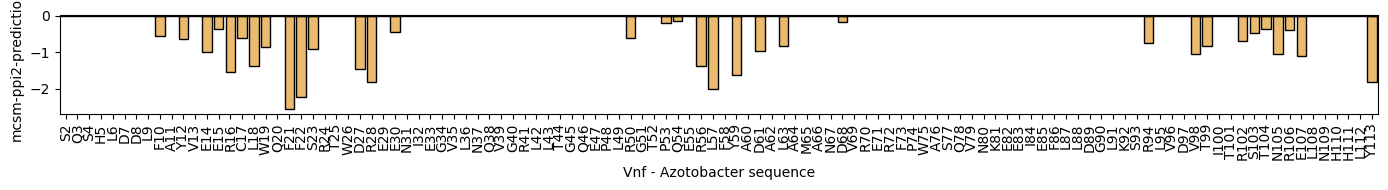

In [43]:
fig, ax = plt.subplots(1)
fig.set_size_inches(14, 2)
sns.barplot(x='coolname', y='mcsm-ppi2-prediction', data=ala_scanning_entropy, color='#FFBF59', edgecolor='black')
#ax.set_xticks(np.arange(len(azov_vnf_g_subunit_sequence)))
#ax.set_xticklabels(list(azov_vnf_g_subunit_sequence))
ax.set_ylabel('mcsm-ppi2-prediction')
ax.set_xlabel('Vnf - Azotobacter sequence')
ax.axhline(0, linewidth=1, color='black')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
# fig.savefig('../figures/fig010.VnfG.AzoV.mcsm2.svg', dpi=300)
plt.show()

### Alanine scanning across time: comparing Ala-Scan results between extant VnfDG and ancestral-Vnf/AnfDG

In [44]:
aligned_D_subunits = pd.read_csv(
    '../data/surface-network/D.subunit.csv', index_col=0
)
aligned_D_subunits['resnum:AzoV.Vnf'] = aligned_D_subunits['resnum:AzoV.Vnf'].astype(pd.Int64Dtype())
aligned_D_subunits['resnum:Anc263'] = aligned_D_subunits['resnum:Anc263'].astype(pd.Int64Dtype())
aligned_D_subunits = aligned_D_subunits.dropna(subset=['resnum:AzoV.Vnf','resnum:Anc263' ])
azov_vnfd_ala_scan = pd.read_csv('../data/mcsm2/AzoV.Vnf.DG.mcsm2.csv').query('chain == "A"').sort_values('res-number')
azov_vnfd_ala_scan['coolname:AzoV.Vnf'] = azov_vnfd_ala_scan.apply(lambda x: "{:s}{:d}".format(seq1(x['wild-type']), x['res-number']), axis=1)
azov_vnfd_ala_scan = azov_vnfd_ala_scan.rename(columns={"res-number":"resnum:AzoV.Vnf", "mcsm-ppi2-prediction":"ala-scan:AzoV.Vnf"})
anc263_ala_scan = pd.read_csv('../data/mcsm2/Anc263.DG.mcsm2.csv').query('chain == "B"').sort_values('res-number')
anc263_ala_scan['coolname:Anc263'] = anc263_ala_scan.apply(lambda x: "{:s}{:d}".format(seq1(x['wild-type']), x['res-number']), axis=1)
anc263_ala_scan = anc263_ala_scan.rename(columns={"res-number":"resnum:Anc263", "mcsm-ppi2-prediction":"ala-scan:Anc263"})
aligned_D_subunits = pd.merge(aligned_D_subunits, azov_vnfd_ala_scan[['resnum:AzoV.Vnf', 'ala-scan:AzoV.Vnf', 'coolname:AzoV.Vnf']], how='left', on='resnum:AzoV.Vnf')
aligned_D_subunits = pd.merge(aligned_D_subunits, anc263_ala_scan[['resnum:Anc263', 'ala-scan:Anc263', 'coolname:Anc263']], how='left', on='resnum:Anc263')
aligned_D_subunits['ala_scan:diff'] = aligned_D_subunits['ala-scan:AzoV.Vnf'] - aligned_D_subunits['ala-scan:Anc263']
aligned_D_subunits['ala_scan:diff2'] = aligned_D_subunits['ala_scan:diff']**2
aligned_D_subunits

,DK.Anc265,DK.Anc264,DKG.Anc262,DKG.Anc263,DKG.Anc330,DKG.AzoV.Anf.pdb,DKG.AzoV.Vnf,map:DK.Anc265,map:DK.Anc264,map:DKG.Anc262,...,index:Anc262,index:Anc330,index:AzoV.Anf,index:AzoV.Vnf,ala-scan:AzoV.Vnf,coolname:AzoV.Vnf,ala-scan:Anc263,coolname:Anc263,ala_scan:diff,ala_scan:diff2
0,P,P,P,P,P,P,P,PRO 2,PRO 2,PRO 2,...,Anc262.PRO2.A,Anc330.PRO2.A,AzoV.Anf.PRO2.A,AzoV.Vnf.PRO2.A,NaN,NaN,NaN,NaN,NaN,NaN
1,F,F,L,F,Y,H,M,PHE 3,PHE 3,LEU 3,...,Anc262.LEU3.A,Anc330.TYR3.A,AzoV.Anf.HIS3.A,AzoV.Vnf.MET3.A,NaN,NaN,NaN,NaN,NaN,NaN
2,V,K,K,K,H,H,V,VAL 4,LYS 4,LYS 4,...,Anc262.LYS4.A,Anc330.HIS4.A,AzoV.Anf.HIS4.A,AzoV.Vnf.VAL4.A,NaN,NaN,NaN,NaN,NaN,NaN
3,L,L,L,L,T,E,L,LEU 5,LEU 5,LEU 5,...,Anc262.LEU5.A,Anc330.THR5.A,AzoV.Anf.GLU5.A,AzoV.Vnf.LEU5.A,NaN,NaN,NaN,NaN,NaN,NaN
4,L,F,F,F,F,F,L,LEU 6,PHE 6,PHE 6,...,Anc262.PHE6.A,Anc330.PHE6.A,AzoV.Anf.PHE6.A,AzoV.Vnf.LEU6.A,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,-,-,L,L,I,L,V,NaN,NaN,LEU 467,...,Anc262.LEU467.A,Anc330.ILE476.A,AzoV.Anf.LEU477.A,AzoV.Vnf.VAL470.A,NaN,NaN,NaN,NaN,NaN,NaN
466,-,-,K,K,S,S,R,NaN,NaN,LYS 468,...,Anc262.LYS468.A,Anc330.SER477.A,AzoV.Anf.SER478.A,AzoV.Vnf.ARG471.A,NaN,NaN,NaN,NaN,NaN,NaN
467,-,-,E,E,D,D,G,NaN,NaN,GLU 469,...,Anc262.GLU469.A,Anc330.ASP478.A,AzoV.Anf.ASP479.A,AzoV.Vnf.GLY472.A,NaN,NaN,NaN,NaN,NaN,NaN
468,-,-,A,K,V,G,A,NaN,NaN,ALA 470,...,Anc262.ALA470.A,Anc330.VAL479.A,AzoV.Anf.GLY480.A,AzoV.Vnf.ALA473.A,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_1924893/2495894781.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


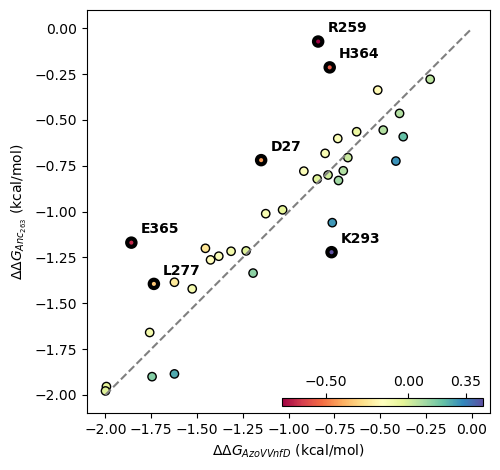

In [45]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
ax.plot([-2.0, 0.0], [-2, 0.0], color='gray',linestyle='--')
cb = ax.scatter(
    data=aligned_D_subunits, y='ala-scan:Anc263', x='ala-scan:AzoV.Vnf',
    c='ala_scan:diff', cmap='Spectral', edgecolors='black'
)

axins1 = inset_axes(ax, width="50%", height="2%", loc="lower right",)

fig.colorbar(cb, cax=axins1, orientation="horizontal", ticks=[-0.50, 0.0, 0.35])
axins1.xaxis.set_ticks_position("top")

for _, outlier in aligned_D_subunits[aligned_D_subunits['ala_scan:diff2'] > 0.1].iterrows():
    ax.text(
        outlier['ala-scan:AzoV.Vnf'] + 0.05, 
        outlier['ala-scan:Anc263'] + 0.05, 
        outlier['coolname:AzoV.Vnf'], 
        horizontalalignment='left', size='medium', color='black', weight='semibold')
    ax.scatter(
        y=outlier['ala-scan:Anc263'], x=outlier['ala-scan:AzoV.Vnf'],
        edgecolors='black', linewidths=3.0, facecolor="none"
    )
ax.set_xlabel('$\Delta \Delta G_{Azo V VnfD}$ (kcal/mol) ')
ax.set_ylabel('$\Delta \Delta G_{Anc_{263}}$ (kcal/mol) ')
fig.tight_layout()
#plt.savefig('../figures/publication/as-azovvnfg_anc263d.svg')
# plt.savefig('../figures/publication/as-azovvnfg_anc263d.png', dpi=300)

In [46]:
aligned_G_subunits = pd.read_csv(
    '../data/surface-network/G.subunit.csv', index_col=0
)
aligned_G_subunits['resnum:AzoV.Vnf'] = aligned_G_subunits['resnum:AzoV.Vnf'].astype(pd.Int64Dtype())
aligned_G_subunits['resnum:Anc263'] = aligned_G_subunits['resnum:Anc263'].astype(pd.Int64Dtype())
aligned_G_subunits = aligned_G_subunits.dropna(subset=['resnum:AzoV.Vnf','resnum:Anc263' ])
azov_vnfd_ala_scan = pd.read_csv('../data/mcsm2/AzoV.Vnf.DG.mcsm2.csv').query('chain == "C"').sort_values('res-number')
azov_vnfd_ala_scan['coolname:AzoV.Vnf'] = azov_vnfd_ala_scan.apply(lambda x: "{:s}{:d}".format(seq1(x['wild-type']), x['res-number']), axis=1)
azov_vnfd_ala_scan = azov_vnfd_ala_scan.rename(columns={"res-number":"resnum:AzoV.Vnf", "mcsm-ppi2-prediction":"ala-scan:AzoV.Vnf"})
anc263_ala_scan = pd.read_csv('../data/mcsm2/Anc263.DG.mcsm2.csv').query('chain == "C"').sort_values('res-number')
anc263_ala_scan['coolname:Anc263'] = anc263_ala_scan.apply(lambda x: "{:s}{:d}".format(seq1(x['wild-type']), x['res-number']), axis=1)
anc263_ala_scan = anc263_ala_scan.rename(columns={"res-number":"resnum:Anc263", "mcsm-ppi2-prediction":"ala-scan:Anc263"})
aligned_G_subunits = pd.merge(aligned_G_subunits, azov_vnfd_ala_scan[['resnum:AzoV.Vnf', 'ala-scan:AzoV.Vnf', 'coolname:AzoV.Vnf']], how='left', on='resnum:AzoV.Vnf')
aligned_G_subunits = pd.merge(aligned_G_subunits, anc263_ala_scan[['resnum:Anc263', 'ala-scan:Anc263', 'coolname:Anc263']], how='left', on='resnum:Anc263')
aligned_G_subunits['ala_scan:diff'] = aligned_G_subunits['ala-scan:AzoV.Vnf'] - aligned_G_subunits['ala-scan:Anc263']
aligned_G_subunits['ala_scan:diff2'] = aligned_G_subunits['ala_scan:diff']**2
aligned_G_subunits

,DKG.Anc262,DKG.Anc263,DKG.Anc330,DKG.AzoV.Anf.pdb,DKG.AzoV.Vnf,map:DKG.Anc262,map:DKG.Anc263,map:DKG.Anc330,map:DKG.AzoV.Anf.pdb,map:DKG.AzoV.Vnf,...,index:Anc262,index:Anc330,index:AzoV.Anf,index:AzoV.Vnf,ala-scan:AzoV.Vnf,coolname:AzoV.Vnf,ala-scan:Anc263,coolname:Anc263,ala_scan:diff,ala_scan:diff2
0,M,M,M,M,S,MET 1,MET 1,MET 5,MET 21,SER 2,...,Anc262.MET1.C,Anc330.MET5.C,AzoV.Anf.MET21.C,AzoV.Vnf.SER2.C,NaN,NaN,NaN,NaN,NaN,NaN
1,K,K,K,D,Q,LYS 2,LYS 2,LYS 6,ASP 22,GLN 3,...,Anc262.LYS2.C,Anc330.LYS6.C,AzoV.Anf.ASP22.C,AzoV.Vnf.GLN3.C,NaN,NaN,NaN,NaN,NaN,NaN
2,D,D,D,A,S,ASP 3,ASP 3,ASP 7,ALA 23,SER 4,...,Anc262.ASP3.C,Anc330.ASP7.C,AzoV.Anf.ALA23.C,AzoV.Vnf.SER4.C,NaN,NaN,NaN,NaN,NaN,NaN
3,K,K,R,R,H,LYS 4,LYS 4,ARG 8,ARG 24,HIS 5,...,Anc262.LYS4.C,Anc330.ARG8.C,AzoV.Anf.ARG24.C,AzoV.Vnf.HIS5.C,NaN,NaN,NaN,NaN,NaN,NaN
4,V,V,V,I,L,VAL 5,VAL 5,VAL 9,ILE 25,LEU 6,...,Anc262.VAL5.C,Anc330.VAL9.C,AzoV.Anf.ILE25.C,AzoV.Vnf.LEU6.C,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,N,N,T,S,N,ASN 108,ASN 108,THR 112,SER 128,ASN 109,...,Anc262.ASN108.C,Anc330.THR112.C,AzoV.Anf.SER128.C,AzoV.Vnf.ASN109.C,NaN,NaN,NaN,NaN,NaN,NaN
108,V,V,D,D,H,VAL 109,VAL 109,ASP 113,ASP 129,HIS 110,...,Anc262.VAL109.C,Anc330.ASP113.C,AzoV.Anf.ASP129.C,AzoV.Vnf.HIS110.C,NaN,NaN,NaN,NaN,NaN,NaN
109,P,P,P,K,H,PRO 110,PRO 110,PRO 114,LYS 130,HIS 111,...,Anc262.PRO110.C,Anc330.PRO114.C,AzoV.Anf.LYS130.C,AzoV.Vnf.HIS111.C,NaN,NaN,-0.204,P110,NaN,NaN
110,N,N,L,H,L,ASN 111,ASN 111,LEU 115,HIS 131,LEU 112,...,Anc262.ASN111.C,Anc330.LEU115.C,AzoV.Anf.HIS131.C,AzoV.Vnf.LEU112.C,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_1924893/3046210572.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


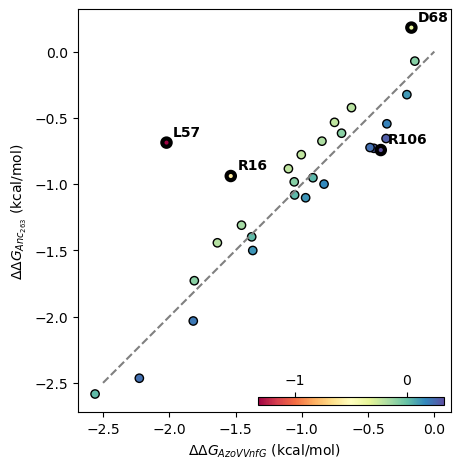

In [47]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
ax.plot([-2.5, 0.0], [-2.5, 0.0], color='gray',linestyle='--')
cb = ax.scatter(
    data=aligned_G_subunits, y='ala-scan:Anc263', x='ala-scan:AzoV.Vnf',
    c='ala_scan:diff', cmap='Spectral', edgecolors='black'
)

axins1 = inset_axes(ax, width="50%", height="2%", loc="lower right",)

fig.colorbar(cb, cax=axins1, orientation="horizontal", ticks=[-1.0, 0.0])
axins1.xaxis.set_ticks_position("top")

for _, outlier in aligned_G_subunits[aligned_G_subunits['ala_scan:diff2'] > 0.1].iterrows():
    ax.text(
        outlier['ala-scan:AzoV.Vnf'] + 0.05, 
        outlier['ala-scan:Anc263'] + 0.05, 
        outlier['coolname:AzoV.Vnf'], 
        horizontalalignment='left', size='medium', color='black', weight='semibold')
    ax.scatter(
        y=outlier['ala-scan:Anc263'], x=outlier['ala-scan:AzoV.Vnf'],
        edgecolors='black', linewidths=3.0, facecolor="none"
    )
ax.set_xlabel('$\Delta \Delta G_{Azo V VnfG}$ (kcal/mol) ')
ax.set_ylabel('$\Delta \Delta G_{Anc_{263}}$ (kcal/mol) ')
fig.tight_layout()
# plt.savefig('../figures/publication/as-azovvnfg_anc263g.svg')
# plt.savefig('../figures/publication/as-azovvnfg_anc263g.png', dpi=300)